In [1]:
#import streamlit as st
import pandas as pd
import geopandas as gpd
import leafmap.colormaps as cm
import pydeck as pdk
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import contextily as cx

## CHECK THE CRS!!!

In [ ]:
#Inspiration from https://towardsdatascience.com/from-kernel-density-estimation-to-spatial-analysis-in-python-64ddcdb6bc9b

In [15]:
from shapely.geometry import Polygon, MultiPolygon

In [2]:
from matplotlib.patches import Rectangle

from leafmap.common import hex_to_rgb
#from dawa_scrape_prod import DAWA_data

from shapely.geometry import Point
from shapely.ops import nearest_points

In [3]:
pd.set_option('display.max_columns', 500)

In [4]:
plt.rcParams.update({
    #"figure.facecolor":  (1.0, 0.0, 0.0, 0.3),  # red   with alpha = 30%
    #"axes.facecolor":    (0.0, 1.0, 0.0, 0.5),  # green with alpha = 50%
    "savefig.facecolor": (0.0, 0.0, 0.0, 0),  # blue  with alpha = 20%
})

COLOR = 'white'
plt.rcParams['text.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR

def custom_round(x, base=5):
    return int(round(float(x*100)/base))

#@st.cache(allow_output_mutation=True)
def get_data(limit=None):
    #read scraped data in
    #df = pd.read_csv('data/final_final_data.csv', sep=';').drop(['Unnamed: 0','Unnamed: 0.1'],axis=1)
    gdf = gpd.read_file('data/final_geodataframe_v2.geojson')

    if limit:
        gdf = gdf.head(limit)

    #convert adjusted_sqm_price to thousand separated integer (string)
    gdf['tooltip_price'] = gdf['adjusted_sqm_price'].astype(int)
    gdf['tooltip_price'] = gdf['tooltip_price'].map('{:,.2f}'.format)

    #strip apartment identifier and store just address for tooltip
    gdf['tooltip_address'] = [a.strip().split(',')[0] for a in gdf['address'].values.tolist()]

    #scale price to get elevation right for plot
    gdf['scaled_adjusted_sqm_price']=(gdf['adjusted_sqm_price']-gdf['adjusted_sqm_price'].min())/(gdf['adjusted_sqm_price'].max()-gdf['adjusted_sqm_price'].min())

    gdf['color_int'] = gdf['scaled_adjusted_sqm_price'].apply(lambda x: custom_round(x,base=5))
    return gdf

#@st.cache
def get_postnumre():
    gdf = gpd.read_file('data/filtered_postnumre.geojson')
    return gdf

#@st.cache
def get_sogne():
    gdf = gpd.read_file('data/sogne.geojson')
    return gdf


def pd_column_to_pretty(pd_column):
    d = {'square_meters_price':'Price m\u00b2',
        'adjusted_sqm_price': 'Adj. price m\u00b2'
    }
    return d[pd_column]


In [5]:
gdf = get_data(limit=5000)

In [6]:
gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

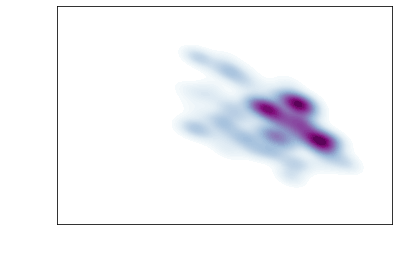

In [7]:
sns.kdeplot(
    gdf["lng"], 
    gdf["lat"], 
    n_levels=50, 
    shade=True, 
    cmap='BuPu'
);

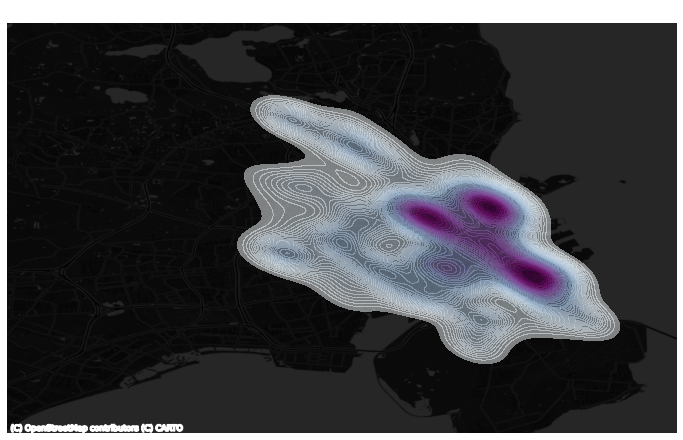

In [27]:
# Setup figure and axis
f, ax = plt.subplots(1, figsize=(12, 12))
# Add KDE layer that displays probability surface
sns.kdeplot(
    gdf["lng"], 
    gdf["lat"], 
    n_levels=50, 
    shade=True, 
    cmap='BuPu',
    alpha = 0.5
)

# Remove axis
ax.set_axis_off()
# Add basemap
cx.add_basemap(
    ax, 
    crs= "EPSG:4326",
    source=cx.providers.CartoDB.DarkMatterNoLabels
)
# Add title of the map
ax.set_title("Kernel Density Estimation of appartment data in Copenhagen")
# Draw map
plt.show()

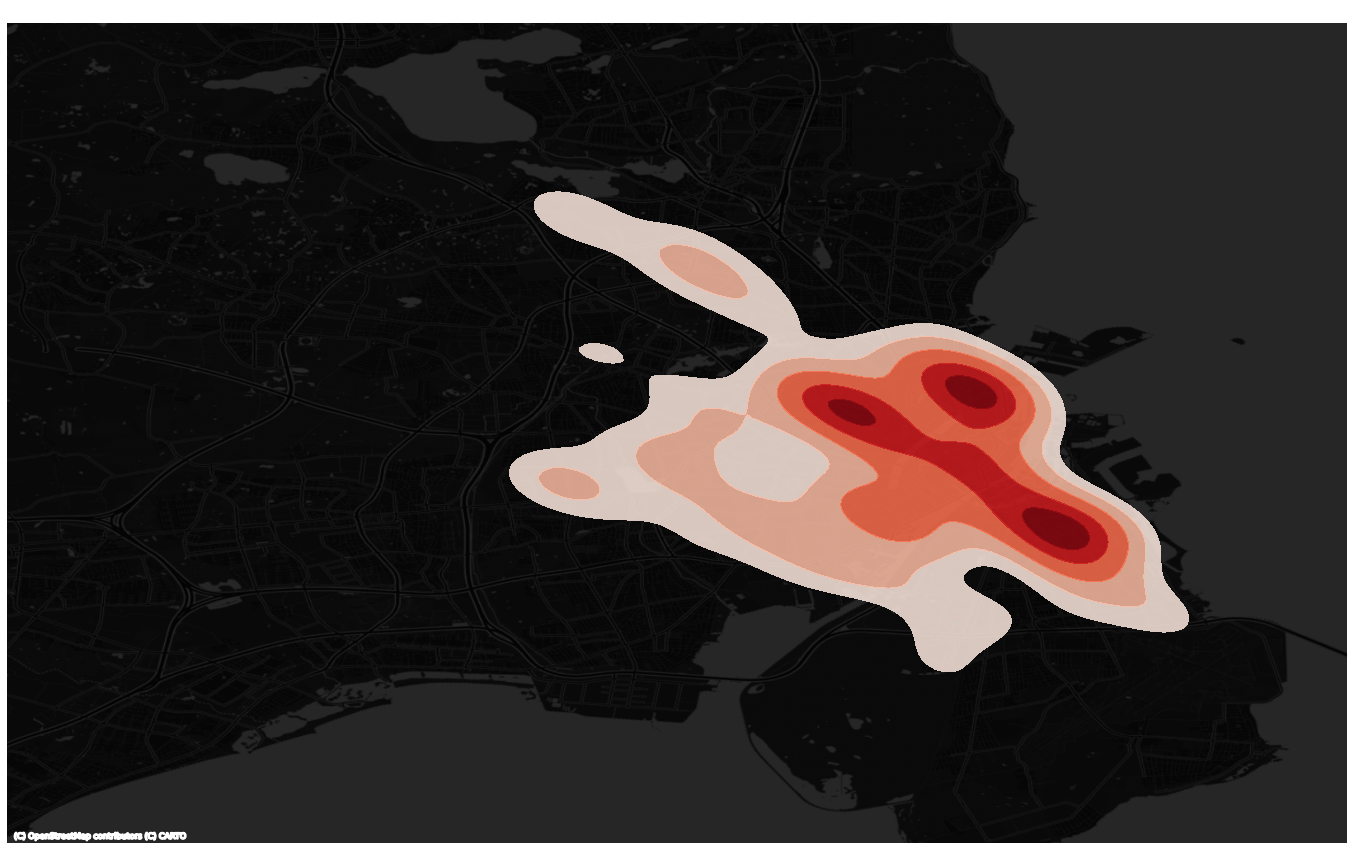

In [46]:
levels = [0.2,0.4,0.6,0.8,0.95,1]

# Setup figure and axis
f, ax = plt.subplots(1, figsize=(18, 18))
# Add KDE layer that displays probability surface

kde = sns.kdeplot(
    ax=ax,
    x=gdf['geometry'].x,
    y= gdf['geometry'].y,
    levels = levels,
    shade=True,
    cmap='Reds',
    alpha=0.85
)

# Remove axis
ax.set_axis_off()
# Add basemap
cx.add_basemap(
    ax, 
    crs= gdf.crs.to_string(),
    source=cx.providers.CartoDB.DarkMatterNoLabels
)
# Add title of the map
ax.set_title("Kernel Density Estimation of appartment data in Copenhagen")
# Save as file
plt.savefig('density_plot.png', dpi=200)
# Draw map
plt.show()

In [50]:
level_polygons = []
i = 0
for col in kde.collections:
    paths = []
    # Loop through all polygons that have the same intensity level
    for contour in col.get_paths(): 
        # Create a polygon for the countour
        # First polygon is the main countour, the rest are holes
        for ncp,cp in enumerate(contour.to_polygons()):
            x = cp[:,0]
            y = cp[:,1]
            new_shape = Polygon([(i[0], i[1]) for i in zip(x,y)])
            if ncp == 0:
                poly = new_shape
            else:
                # Remove holes, if any
                poly = poly.difference(new_shape)

        # Append polygon to list
        paths.append(poly)
    # Create a MultiPolygon for the contour
    multi = MultiPolygon(paths)
    # Append MultiPolygon and level as tuple to list
    level_polygons.append((levels[i], multi))
    i+=1

In [51]:
# Create DataFrame
df = pd.DataFrame(level_polygons, columns =['level', 'geometry'])
# Convert to a GeoDataFrame
geo = gpd.GeoDataFrame(df, geometry='geometry', crs = gdf.crs)
# Set CRS for geometric operations
geo = geo.to_crs(gdf.crs.to_string())
# Calculate area
geo['area'] = geo['geometry'].area
# Save to file
#geo.to_file('geo_file.gpkg', driver='GPKG')

In [53]:
#sort acording to level, descending
geo = geo.sort_values('level', ascending=False).reset_index(drop=True)
geo

,level,geometry,area
0,0.95,"MULTIPOLYGON (((12.60888 55.65608, 12.61100 55...",0.000373
1,0.80,"MULTIPOLYGON (((12.61312 55.65108, 12.61100 55...",0.001352
2,0.60,"MULTIPOLYGON (((12.61312 55.64632, 12.61100 55...",0.002388
3,0.40,"MULTIPOLYGON (((12.57707 55.63410, 12.57708 55...",0.003837
4,0.20,"MULTIPOLYGON (((12.56842 55.61859, 12.56694 55...",0.005789


In [63]:
apartments = gdf.geometry.tolist()

sales_density_levels = geo['level'].tolist()
sales_density_geometry = geo.geometry.tolist()

sales_density_score = []
for a in apartments:
    for idx, level in enumerate(sales_density_geometry):
        found = False
        if a.intersects(level):
            #print(idx)
            sales_density_score.append(sales_density_levels[idx])
            found = True
            break
    if not found:
        sales_density_score.append(0)

gdf['kde_sales_density'] = sales_density_score

In [67]:
gdf[['address','city','scaled_adjusted_sqm_price','kde_sales_density']]

,address,city,scaled_adjusted_sqm_price,kde_sales_density
0,"Brøndbyvestervej 36, 1. th",Brøndby,0.147428,0.00
1,Sortemosevej 130,Herlev,0.248724,0.00
2,Kamdalen 18A,Herlev,0.178596,0.00
3,"Klokkedybet 3, st. c",Herlev,0.134244,0.00
4,"Fagotvej 14, st. tv",Herlev,0.149384,0.00
...,...,...,...,...
4995,"Bogensegade 7, st. th",København Ø,0.308423,0.95
4996,"Birkegade 28, 2. th",København N,0.393925,0.80
4997,"Amagerbrogade 15, 1. tv",København S,0.234554,0.80
4998,"Stockholmsgade 61, 4. mf",København Ø,0.431298,0.60


In [66]:
gdf

,address,address_url,adjusted_sqm_price,air,city,energy,factor,faulty,final_url,id,idx,kommune,lat,latest_sale_date,latest_sale_price,lng,min_dist_to_bar,min_dist_to_cafe,min_dist_to_coastline,min_dist_to_college,min_dist_to_grocery,min_dist_to_kindergarten,min_dist_to_restaurant,min_dist_to_school,min_dist_to_supermarket,min_dist_to_university,min_dist_to_water,noise,postal,sognekode,square_meters,square_meters_price,tmp_address,year,geometry,tooltip_price,tooltip_address,scaled_adjusted_sqm_price,color_int,kde sales density,kde_sales_density
0,"Brøndbyvestervej 36, 1. th",2605-brøndby,28670.886076,"[12.0, 10.0, 15.8, 0.4]",Brøndby,D,1.000,False,https://www.dingeo.dk/adresse/2605-br%C3%B8ndb...,0,0,brøndby,55.658384,09-02-2022,2265000,12.408499,951.662301,566.024918,5059.015726,1985.624169,1868.263978,337.118558,827.322936,611.867063,516.251242,3699.926755,573.555232,55-60,2605,7147,79,28670.886076,brøndbyvestervej-36/1-th,2022,POINT (12.40850 55.65838),"28,670.00",Brøndbyvestervej 36,0.147428,3,0.00,0.00
1,Sortemosevej 130,2730-herlev,44070.000000,"[13.0, 10.6, 16.8, 0.4]",Herlev,C,1.000,False,https://www.dingeo.dk/adresse/2730-herlev/sort...,1,244,herlev,55.758909,16-11-2022,4407000,12.395060,2783.124323,2063.646349,12027.545730,2580.967833,6725.606020,868.066449,1937.154057,507.718033,1109.395972,2921.605882,616.376298,< 55,2730,9074,100,44070.000000,sortemosevej-130,2022,POINT (12.39506 55.75891),"44,070.00",Sortemosevej 130,0.248724,5,0.00,0.00
2,Kamdalen 18A,2730-herlev,33409.090909,"[13.0, 10.3, 16.1, 0.4]",Herlev,E,1.000,False,https://www.dingeo.dk/adresse/2730-herlev/kamd...,2,245,herlev,55.735734,16-02-2022,3675000,12.415977,1143.043405,1076.098845,10238.993842,1977.064923,5766.517689,344.107553,908.918135,508.933440,280.160789,1094.954178,508.376298,< 55,2730,9074,110,33409.090909,kamdalen-18a,2022,POINT (12.41598 55.73573),"33,409.00",Kamdalen 18A,0.178596,4,0.00,0.00
3,"Klokkedybet 3, st. c",2730-herlev,26666.666667,"[14.0, 10.2, 16.1, 0.4]",Herlev,E,1.000,False,https://www.dingeo.dk/adresse/2730-herlev/klok...,3,246,herlev,55.717491,21-01-2022,960000,12.457055,878.682142,483.561380,7639.096233,3536.032897,3598.617508,213.749985,436.992813,834.243721,526.458541,3818.318751,460.504329,65-70,2730,7136,36,26666.666667,klokkedybet-3/st-c,2022,POINT (12.45706 55.71749),"26,666.00",Klokkedybet 3,0.134244,3,0.00,0.00
4,"Fagotvej 14, st. tv",2730-herlev,28968.253968,"[22.0, 11.4, 19.3, 0.6]",Herlev,D,1.000,False,https://www.dingeo.dk/adresse/2730-herlev/fago...,4,247,herlev,55.717952,13-01-2022,1825000,12.440005,827.421658,502.252896,8700.101802,3717.228494,3539.972696,223.871353,654.424352,662.650879,135.198401,2830.342305,958.522058,55-60,2730,7136,63,28968.253968,fagotvej-14/st-tv,2022,POINT (12.44000 55.71795),"28,968.00",Fagotvej 14,0.149384,3,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,"Bogensegade 7, st. th",2100-københavn-ø,53145.491803,"[14.0, 10.4, 16.6, 0.4]",København Ø,D,0.975,False,https://www.dingeo.dk/adresse/2100-k%C3%B8benh...,4999,9876,københavn-ø,55.708656,17-05-2021,3325000,12.580747,199.300228,191.635074,617.989479,1318.309565,2993.200756,60.538236,199.146347,70.676851,142.431975,1263.263815,1236.603135,< 55,2100,9175,61,54508.196721,bogensegade-7/st-th,2021,POINT (12.58075 55.70866),"53,145.00",Bogensegade 7,0.308423,6,0.95,0.95
4996,"Birkegade 28, 2. th",2200-københavn-n,66143.518519,"[26.0, 11.4, 19.1, 0.6]",København N,Unknown,0.975,False,https://www.dingeo.dk/adresse/2200-k%C3%B8benh...,5000,9877,københavn-n,55.691229,17-05-2021,5495000,12.558538,67.292038,39.983423,1979.403891,728.246400,1390.172702,288.112622,58.356895,179.792951,226.871038,237.211330,476.265916,60-65,2200,9169,81,67839.506173,birkegade-28/2-th,2021,POINT (12.55854 55.69123),"66,143.00",Birkegade 28,0.393925,8,0.80,0.80
4997,"Amagerbrogade 15, 1. tv",2300-københavn-s,41915.887850,"[26.0, 1